# Towards an ICCM paper

This notebook will have two parts. The first will make predictions about reading times (to start, for local coherence effects) from the equations of motion. The second will test the hypothesis that, in the model, the average reading time is monotonically dependent on the relative harmony values of two competing peaks.

To test both of these ideas, we'll use a 2D harmony landscape with two attractors, one at [1, 0] and the other at [0, 1]. The attractor at [1, 0] will be the grammatical parse $\mathbf{x}_g$, and [0, 1] will be the ungrammatical parse $\mathbf{x}_u$.

## Part the first: A line integral approach to predicting reading times

(This is taken largely from [here](http://tutorial.math.lamar.edu/Classes/CalcIII/LineIntegralsPtI.aspx) and Boas (1983, *Mathematical methods in the physical sciences*, Wiley).

The time to travel some distance along a curve $C$ is equal to the distance traveled divided by the speed of travel. Thus, we're looking for an equation of the form $T = dist / speed$. In the general case of $n$-dimensions, this will be a path integral $T = \int_C \mathbf{F}\cdot d\mathbf{r}$, where $\mathbf{F}$ is some vector field and $d\mathbf{r}$ is derivative along the curve $C$, where $C$ has been parameterized using some function $\mathbf{r}(t)$. Ideally, we would define the curve $C$ to be the actual path defined by the dynamics, but that would require an explicit solution to the differential equation $\dot{\mathbf{x}} = \nabla H(\mathbf{x})$, which we don't have. Instead, I'm approximating the actual solution curve with a straight line connecting the initial state $\mathbf{x}_{init}$ and some final state $\mathbf{x}_{fin}$ close to $\mathbf{x}_g$ or $\mathbf{x}_u$.

We want to see how long it takes to get from $\mathbf{x}_{init}$ to $\mathbf{x}_{fin}$, so the force $\mathbf{F}$ from above becomes $\nabla H(\mathbf{x})^{-1}$:
$$
T = \int_C \nabla H(\mathbf{x})^{-1}\cdot d\mathbf{r}
$$
We need to make $H(\cdot)^{-1}$ a function of the 1D position along the curve, so that means writing each element $x_j$ of the state vector $\mathbf{x}$ as function of that position. This position along the curve is given by 
$$
\mathbf{r}(t) = (1 - t)\mathbf{x}_{init} + t\mathbf{x}_{fin}
$$
for $0 \leq t \leq 1$. Note that this parameterization equals $\mathbf{x}_{init}$ at $t = 0$ and $\mathbf{x}_{fin}$ at $t = 1$. With 
$$
d\mathbf{r} = (-\mathbf{x}_0 + \mathbf{x}_1) dt
$$
the integral becomes
$$
T = \int_0^1 \left(\nabla H(\mathbf{r}(t))^{-1}\cdot (-\mathbf{x}_0 + \mathbf{x}_1)\right)dt
$$
which can be evaluated numerically.

In [1]:
# Setting up things in SymPy
from sympy import *
from IPython.display import display

# Declaring scalars
# x0, x1 are the dimensions
x0, x1, h0, h1, gamma, t = symbols('x0 x1 h0 h1 gamma t')  # make these formal symbols for SymPy to manipulate
# x{0, 1}{i, f} are the initial and final positions for the two spatial dimensions
x0i, x1i, x0f, x1f = symbols('x0i x1i x0f x1f')
h0 = 1.0
h1 = 0.5  # For initial testing
gamma = 0.25

# Declaring vectors
x = Matrix([x0, x1])  # state vector
cg = Matrix([1, 0])  # centers of the RBFs
cu = Matrix([0, 1])
xinit = Matrix([x0i, x1i])  # placeholders for now
xfin = Matrix([x0f, x1f])
t1 = Matrix([1-t, 1-t])  # Vectors for calculating r(t)
justt = Matrix([t, t])

H = h0*exp(-(x-cg).dot(x-cg) / gamma) + h1*exp(-(x-cu).dot(x-cu) / gamma)  # defining the harmony function
dxdt = Matrix([diff(H, i) for i in x])
r = xinit.multiply_elementwise(t1) + xfin.multiply_elementwise(justt)
dr = (-xinit + xfin)
display(H, dxdt, r, dr)

0.5*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2) + 1.0*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2)

Matrix([
[-4.0*x0*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2) + 1.0*(-8.0*x0 + 8.0)*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2)],
[-8.0*x1*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2) + 0.5*(-8.0*x1 + 8.0)*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2)]])

Matrix([
[t*x0f + x0i*(-t + 1)],
[t*x1f + x1i*(-t + 1)]])

Matrix([
[x0f - x0i],
[x1f - x1i]])

In [2]:
# Calculating the locations of the fixed points
xg = nsolve(dxdt, x, (1, 0))
xu = nsolve(dxdt, x, (0, 1))
xmid = nsolve(dxdt, x, (0.5, 0.5))
print('x_g = {}\nx_u = {}\nsaddle = {}'.format(xg, xu, xmid))

x_g = Matrix([[0.999831845081734], [0.000168154918266462]])
x_u = Matrix([[0.000677780997818818], [0.999322219002181]])
saddle = Matrix([[0.442150996291071], [0.557849003708929]])


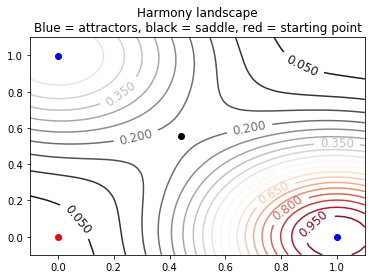

In [3]:
# Plotting the harmony landscape and fixed points
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

Hnum = lambdify(x, H)  # Making a numerical version of the symbolic function
delta = 0.025  # Grid size for calculating the harmony
xx1 = np.arange(-0.1, 1.1, delta)
xx2 = np.arange(-0.1, 1.1, delta)
Z = np.zeros((len(xx1), len(xx2)))  # Harmony
for i, j in product(range(len(xx1)), range(len(xx2))):
    Z[i, j] = Hnum(xx1[i], xx2[j])


# Making the contour plot
clines = plt.contour(xx1, xx2, Z.T, 20, cmap='RdGy_r')
plt.clabel(clines, clines.levels[::3], inline=True, fontsize=12)
# Marking the fixed pts.
plt.plot(xg[0], xg[1], marker='o', color='blue')
plt.plot(xu[0], xu[1], marker='o', color='blue')
plt.plot(xmid[0], xmid[1], marker='o', color='k')
plt.plot(0, 0, marker='o', color='red')  # init. condition
plt.title('Harmony landscape\nBlue = attractors, black = saddle, red = starting point')
plt.show()

In [4]:
# Now we can calculate the integral shown above
# Takes a few seconds...
integrand = Matrix(np.reciprocal(dxdt.subs({x0: r[0], x1: r[1]})))
integrand.dot(dr)  # 
integrand_g = (integrand.dot(dr)).subs({x0i: 0, x1i: 0, x0f: xg[0]-0.1, x1f: xg[1]-0.1})
Tg = Integral(integrand_g, (t, 0, 1)).evalf()
integrand_u = (integrand.dot(dr)).subs({x0i: 0, x1i: 0, x0f: xu[0]-0.1, x1f: xu[1]-0.1})
Tu = Integral(integrand_u, (t, 0, 1)).evalf()
print('Time to grammatical = {}\nTime to ungrammatical = {}'.format(Tg, Tu))

Time to grammatical = 0.618841121217809
Time to ungrammatical = 2.24774354722145


In [5]:
# Changing the harmony height of the ungrammatical parse:
integrand_u = (integrand.dot(dr)).subs({h1: 0.25, x0i: 0, x1i: 0, x0f: xu[0]-0.1, x1f: xu[1]-0.1})
Tu2 = Integral(integrand_u, (t, 0, 1)).evalf()
print('Time to ungrammatical (h1 = 0.25) = {}'.format(Tu2))

Time to ungrammatical (h1 = 0.25) = 5.58320971411626


### Summing up so far

So, it looks like the line integral approach is making coherent predictions about settling times to different attractors: Higher-harmony attractors are approached faster than lower-harmony ones.

The overall theory of reading times here is that the overall average time is the weighted average of how long it takes to settle to each attractor weighted by how often the system goes to that attractor. We now have predictions about how fast it takes to get to each attractor, now we want to look at how often it goes to each one.

**Let's assume dyn. w/i an attr. basin is approx. by single Gaussian, which is analytically simpler (pos. linearize w/i attr. basin).**

## Part the second: Relative harmony heights and reading times

Here's the plan for this part: Start with the two harmony peaks at the same height $h_0 = h_1 = 1.0$. Do 2000 runs (using 1000 was still a bit noisy) with $\mathbf{x}_{init} = [0, 0]^\intercal$, $h_0 = 1.0$, and $\gamma = 0.25$, recording which attractor is chosen and how long it takes. After that, I'll gradually lower $h_1$ in increments of 0.05. The hope is that the mean RT for all runs will decrease as $h_1 \rightarrow 0.0$. The lower harmony of $\mathbf{x}_1$ should, on the one hand, make approaches to it much slower, on the other hand, $\mathbf{x}_0$ will be chosen more often, so the average RT should go down.

In [6]:
# Running the Monte-Carlo simulations
import pandas as pd

centers = np.array([[1, 0], [0, 1]])
harmonies = np.array([1.0, 1.])
gamma = 0.25
ndim = centers.shape[1]
D = 0.001  # Small noise
maxsteps = 1000
tau = 0.01
xinit = np.array([0, 0.])  # starting at the midpoint between the two attractors


# Defining functions
def phi(x, center, gamma):
    """RBF centers"""
    l2norm = np.linalg.norm(x - center)
    return np.exp(-l2norm**2 / gamma)


def calc_harmony(x, centers, harmonies, gamma):
    """Calculate the harmony at a given position"""
    harmony = 0
    for c in range(centers.shape[0]):
        harmony += harmonies[c] * phi(x, centers[c], gamma)
    return harmony


def step_dyn(x, centers, harmonies, gamma):
    """Iterate the discretized dynamics"""
    dx = np.zeros(x.shape)
    mult = -2./gamma
    for c in range(centers.shape[0]):
        dx += (mult * harmonies[c]
               * (x - centers[c]) * phi(x, centers[c], gamma))
    return dx


def not_close(x, centers, tol):
    """Returns True if not close to one of the centers"""
    l2norm = np.zeros(centers.shape[0])
    for c in range(centers.shape[0]):
        diff = x - centers[c]
        l2norm[c] = np.sqrt(np.dot(diff, diff))
    if np.any(l2norm < tol):
        return False
    else:
        return True

# Running
xhist = np.zeros((maxsteps, ndim))
nruns = 2000
data_list = []
hvals = np.arange(1.0, 0.0, -0.05)

for h in range(len(hvals)):
    harmonies[1] = hvals[h]
    print('\nh_1 = {}'.format(hvals[h]))
    for run in range(nruns):
        if run % 500 == 0:
            print('[{}] '.format(run), end='')
        xhist[0,] = xinit
        noise = np.random.normal(0, 1, xhist.shape)
        t = 0
        while t < maxsteps-1:
            if not_close(xhist[t], centers, 0.1):
                xhist[t+1,] = (xhist[t,] + tau*step_dyn(xhist[t,], centers, harmonies, gamma)
                              + np.sqrt(2*D*tau)*noise[t,])
                t += 1
            else:
                break
        if np.all(np.round(xhist[t,]) == centers[0,]):
            data_list.append([hvals[h], 'A', t])
        elif np.all(np.round(xhist[t,]) == centers[1,]):
            data_list.append([hvals[h], 'B', t])
        else:
            data_list.append([hvals[h], 'Other', t])

    if nruns == 1:
        plt.plot(xhist)
        plt.show()

data = pd.concat([pd.DataFrame([i], columns=('Harmony1', 'Attractor', 'Time')) for i in data_list])


h_1 = 1.0
[0] [500] [1000] [1500] 
h_1 = 0.95
[0] [500] [1000] [1500] 
h_1 = 0.8999999999999999
[0] [500] [1000] [1500] 
h_1 = 0.8499999999999999
[0] [500] [1000] [1500] 
h_1 = 0.7999999999999998
[0] [500] [1000] [1500] 
h_1 = 0.7499999999999998
[0] [500] [1000] [1500] 
h_1 = 0.6999999999999997
[0] [500] [1000] [1500] 
h_1 = 0.6499999999999997
[0] [500] [1000] [1500] 
h_1 = 0.5999999999999996
[0] [500] [1000] [1500] 
h_1 = 0.5499999999999996
[0] [500] [1000] [1500] 
h_1 = 0.49999999999999956
[0] [500] [1000] [1500] 
h_1 = 0.4499999999999995
[0] [500] [1000] [1500] 
h_1 = 0.39999999999999947
[0] [500] [1000] [1500] 
h_1 = 0.3499999999999994
[0] [500] [1000] [1500] 
h_1 = 0.2999999999999994
[0] [500] [1000] [1500] 
h_1 = 0.24999999999999933
[0] [500] [1000] [1500] 
h_1 = 0.1999999999999993
[0] [500] [1000] [1500] 
h_1 = 0.14999999999999925
[0] [500] [1000] [1500] 
h_1 = 0.0999999999999992
[0] [500] [1000] [1500] 
h_1 = 0.049999999999999156
[0] [500] [1000] [1500] 

In [7]:
# Checking to make sure it saved alright
print(data.head())
print(data.tail())

   Harmony1 Attractor  Time
0       1.0         A   186
0       1.0         A   154
0       1.0         B   142
0       1.0         A   147
0       1.0         A   183
   Harmony1 Attractor  Time
0      0.05         A   132
0      0.05         A   111
0      0.05         A   150
0      0.05         A   155
0      0.05         A   137


In [8]:
# Basic descriptive statistics
data.groupby('Harmony1').describe()

Time                                                        
           count      mean        std    min    25%    50%    75%    max
Harmony1                                                                
0.05      2000.0  144.1675  21.081263   97.0  130.0  141.0  155.0  310.0
0.10      2000.0  145.3515  22.234773   99.0  130.0  142.0  155.0  327.0
0.15      2000.0  143.9235  20.074814   99.0  130.0  141.0  154.0  292.0
0.20      2000.0  144.5870  21.044307  101.0  130.0  142.0  156.0  352.0
0.25      2000.0  144.9955  20.630543  100.0  130.0  142.0  157.0  290.0
0.30      2000.0  146.1955  20.439623   95.0  132.0  143.0  157.0  234.0
0.35      2000.0  145.9365  21.873927  100.0  131.0  142.0  157.0  340.0
0.40      2000.0  147.8495  23.095596  101.0  133.0  144.0  159.0  455.0
0.45      2000.0  148.2420  23.875185  104.0  132.0  145.0  159.0  360.0
0.50      2000.0  149.7185  24.802537   99.0  134.0  146.0  161.0  341.0
0.55      2000.0  151.4540  25.815424  106.0  134.0  147.0  163.0  288.0
0.60      2000.0  152.7470  27.030174   97.0  135.0  148.0  165.0  359.0
0.65      2000.0  154.2245  27.933067  102.0  134.0  149.0  168.0  319.0
0.70      2000.0  156.2310  28.521770  100.0  136.0  150.0  170.0  293.0
0.75      2000.0  158.6510  27.762035  102.0  139.0  154.0  175.0  297.0
0.80      2000.0  158.5575  27.323012   99.0  140.0  154.0  173.0  280.0
0.85      2000.0  159.8265  26.264602  102.0  140.0  157.0  175.0  295.0
0.90      2000.0  158.1280  24.404024   97.0  140.0  155.0  173.0  267.0
0.95      2000.0  156.0740  23.874390  105.0  138.0  152.0  169.0  278.0
1.00      2000.0  152.3600  22.774322  101.0  136.0  148.0  165.0  283.0

In [9]:
data.groupby(['Attractor', 'Harmony1']).describe()  # basic info by attractor

Time                                               \
                     count        mean        std    min     25%    50%   
Attractor Harmony1                                                        
A         0.05      2000.0  144.167500  21.081263   97.0  130.00  141.0   
          0.10      2000.0  145.351500  22.234773   99.0  130.00  142.0   
          0.15      2000.0  143.923500  20.074814   99.0  130.00  141.0   
          0.20      2000.0  144.587000  21.044307  101.0  130.00  142.0   
          0.25      2000.0  144.995500  20.630543  100.0  130.00  142.0   
          0.30      2000.0  146.195500  20.439623   95.0  132.00  143.0   
          0.35      1999.0  145.859930  21.609636  100.0  131.00  142.0   
          0.40      1998.0  147.617618  21.886536  101.0  133.00  144.0   
          0.45      1996.0  147.950902  22.889899  104.0  132.00  145.0   
          0.50      1990.0  149.166834  23.533708   99.0  134.00  145.0   
          0.55      1966.0  150.029502  23.288765  106.0  134.00  147.0   
          0.60      1948.0  150.622177  23.440665   97.0  134.00  147.0   
          0.65      1910.0  151.454450  24.445785  102.0  134.00  148.0   
          0.70      1829.0  152.028978  24.769169  100.0  135.00  147.0   
          0.75      1757.0  154.065452  24.698771  102.0  137.00  150.0   
          0.80      1640.0  152.682317  23.242435   99.0  137.00  149.0   
          0.85      1491.0  154.092555  24.350754  102.0  137.00  150.0   
          0.90      1335.0  153.886142  23.458226   97.0  137.00  150.0   
          0.95      1144.0  152.595280  22.460301  105.0  136.00  149.0   
          1.00       999.0  152.516517  23.182328  101.0  136.00  148.0   
B         0.35         1.0  299.000000        NaN  299.0  299.00  299.0   
          0.40         2.0  379.500000  47.376154  346.0  362.75  379.5   
          0.45         4.0  293.500000  56.671568  229.0  256.00  296.0   
          0.50        10.0  259.500000  27.913557  223.0  250.50  253.0   
          0.55        34.0  233.823529  31.035142  183.0  203.25  241.5   
          0.60        52.0  232.346154  32.070318  169.0  207.00  229.0   
          0.65        90.0  213.011111  32.366752  157.0  191.25  209.0   
          0.70       171.0  201.175439  27.327506  153.0  182.00  196.0   
          0.75       243.0  191.806584  26.143747  132.0  176.50  188.0   
          0.80       360.0  185.322222  28.541453  133.0  166.00  180.5   
          0.85       509.0  176.622790  24.416077  115.0  160.00  172.0   
          0.90       665.0  166.643609  24.054047  111.0  149.00  164.0   
          0.95       856.0  160.723131  24.908097  112.0  142.75  157.0   
          1.00      1001.0  152.203796  22.370213  105.0  137.00  148.0   

                                   
                       75%    max  
Attractor Harmony1                 
A         0.05      155.00  310.0  
          0.10      155.00  327.0  
          0.15      154.00  292.0  
          0.20      156.00  352.0  
          0.25      157.00  290.0  
          0.30      157.00  234.0  
          0.35      157.00  340.0  
          0.40      159.00  455.0  
          0.45      159.00  360.0  
          0.50      161.00  341.0  
          0.55      162.00  288.0  
          0.60      163.00  359.0  
          0.65      165.00  284.0  
          0.70      165.00  293.0  
          0.75      168.00  292.0  
          0.80      164.00  264.0  
          0.85      168.00  295.0  
          0.90      167.50  267.0  
          0.95      165.00  266.0  
          1.00      165.50  283.0  
B         0.35      299.00  299.0  
          0.40      396.25  413.0  
          0.45      333.50  353.0  
          0.50      268.75  323.0  
          0.55      264.50  277.0  
          0.60      250.00  302.0  
          0.65      234.75  319.0  
          0.70      218.00  285.0  
          0.75      205.50  297.0  
          0.80      201.00  280.0  
          0.85      190.00  270.0  
          0.90      18

In [10]:
# Calculating descriptive statistics for plotting
byharmony = data.groupby(['Harmony1', 'Attractor']).agg('count')
props = byharmony.groupby(level=0).apply(lambda x: x / x.sum())
propa = props.xs('A', level=1)  # Proportions of A-parses by h1 harmony

means = data.groupby('Harmony1').describe().iloc[:, 1]  # Mean settling times

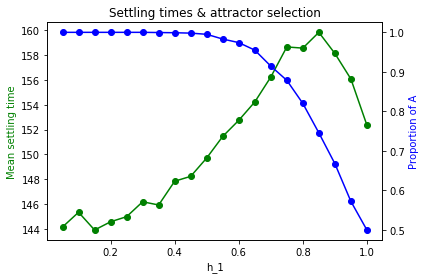

In [11]:
# Making a figure of mean settling time and proportion of A attractors
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(hvals[::-1], means, 'g-o')
ax2.plot(hvals[::-1], propa, 'b-o')

ax1.set_xlabel('h_1')
ax1.set_ylabel('Mean settling time', color='g')
ax2.set_ylabel('Proportion of A', color='b')
plt.title('Settling times & attractor selection')
plt.show()

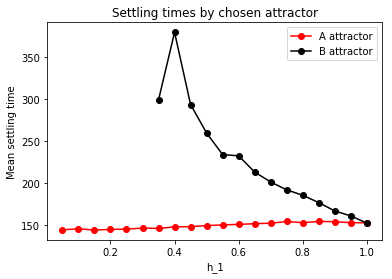

In [12]:
# Looking at the settling times by attractor chosen and h1
rts = data.groupby(['Attractor', 'Harmony1']).describe().iloc[:, 1]
plt.plot(hvals[::-1], rts.xs('A'), 'r-o', label='A attractor')
plt.plot(hvals[0:14,][::-1], rts.xs('B'), 'k-o', label='B attractor')
plt.title('Settling times by chosen attractor')
plt.ylabel('Mean settling time')
plt.xlabel('h_1')
plt.legend()
plt.show()


## Discussion

In this second part, we see an unexpected nonlinear relationship between the relative harmony heights and the settling times. One part of our expectation was borne out: When one attractor has high harmony and the other attractor has low harmony, the average settling times were fast. The system always chooses the high-harmony attractor, and it gets there fast due to its high harmony.

As the harmony of the lower-harmony peak increases, so does the average settling time. But this pattern only holds for a while. After the lower-harmony peak reaches about $h_1 = 0.9$, the average settling time starts to *decrease*. This is because the system starts choosing the lower-harmony peak more often at the same as it's getting faster to approach that attractor. When the two attractors have equal harmony (1.0), the average reading time is still higher than when the two were very unbalanced in harmony.

This makes a really interesting and, as far as I know, unique prediction for sentence processing. When there are two parses available, one high- and one low-harmony, reading times should be fast because the parser will easily choose the high-harmony parse. Reading times should be slower when the two parses are evenly matched in harmony. But this  competition-based slowdown should actually be stronger when the competing parses are only slightly unbalanced in their well-formedness.

The tricky news: picking the $h_i$ is really important because of the nonlinear relationship between it and settling times. 

Model is generally plausible: it seems to get things roughly right, esp. increasing green curve for high competition makes sense for a lot of psycholing. data. But there's a non-trivial subtlety in the up ranges that hasn't been tested yet.

Ambiguity advantage?: "the driver/car of the car/driver with the mustache" both show interference, which might be part of upper part of green curve. Some (Vasishth, Ferreira) seem to want dual attch., but we might expect this to fall out of nature of dyn.... Something like GP would be big difference between harmonies of competitors.

Need compelling reason to use this approach, and then say, "Look, it makes this really cool prediction." Selling points: predicts errant behaviors via normal processing, and we have principled analysis to understand them. 

**Look at how the green curve relates to the black and red ones: is it just weighted by the blue curve.**

**Pos. have one simpler model for illustration/details and another full-fledged one for generality.**

# Part the third: Varying gamma and h together -> 3D plot

Track down PW's comment on rel. mag. of eigenvalues of dyn. and noise mag.: There, he was concerned with the baseline constraint, the strength of which should be greater than the largest absolute eigenvalue of the grammatical weight matrix. For our purposes, I think we can make an analogous approach: For the deterministic dynamics to dominate trajectories near a fixed point, the eigenvalues of the Jacobian matrix should be larger than the eigenvalues of the noise magnitude matrix. Since the noise magnitude matrix is a diagonal matrix with identical values $D$, the largest absolute eigenvalue of the Jacobian should be greater than $D = 0.001$.

If gamma gets too large, we only have a single peak (blend state), but if it's too small, it's just a random walk in a flat harmony landscape. Also, what does gamma mean *in the theory*? Part of a theory of learning?

**Contact Till @ stoch. an. (& diss. date).**

For the simulations below, I will do 1000 runs of the system keeping $h_0$ constant and varying both $\gamma$ and $h_1$. Muezzinoglu & Zurada (2006) show that for equal $\gamma$s and two attractors, there will be separate attractors as long as $\gamma < \Vert\mathbf{c}_0 - \mathbf{c}_1\Vert_2^2 / 2$. Since the centers are at [1, 0] and [0, 1], $\gamma$ should be less than $\frac{\sqrt{2}}{2} \approx 0.71$ and greater than $D = 0.001$. $h_1$ will range from 0.1 to 1.0.

In [40]:
# Running the simulations
xhist = np.zeros((maxsteps, ndim))
nruns = 1000
data_list = []
gridsize = 0.1
hvals = np.arange(0.1, 1.1, gridsize)
gvals = np.arange(0.1, 0.8, gridsize)

for g in range(len(gvals)):
    gamma = gvals[g]
    print('gamma = {}'.format(gamma))
    for h in range(len(hvals)):
        harmonies[1] = hvals[h]
        print('h_1 = {}'.format(hvals[h]), end=' ')
        for run in range(nruns):
            #if run % 100 == 0:
            #    print('[{}] '.format(run), end='')
            xhist[0,] = xinit
            noise = np.random.normal(0, 1, xhist.shape)
            t = 0
            while t < maxsteps-1:
                if not_close(xhist[t], centers, 0.1):
                    xhist[t+1,] = (xhist[t,] + tau*step_dyn(xhist[t,], centers, harmonies, gamma)
                                   + np.sqrt(2*D*tau)*noise[t,])
                    t += 1
                else:
                    break
            if np.all(np.round(xhist[t,]) == centers[0,]):
                data_list.append([gvals[g], hvals[h], 'A', t])
            elif np.all(np.round(xhist[t,]) == centers[1,]):
                data_list.append([gvals[g], hvals[h], 'B', t])
            else:
                data_list.append([gvals[g], hvals[h], 'Other', t])


gamma = 0.1
h_1 = 0.1h_1 = 0.2h_1 = 0.30000000000000004h_1 = 0.4h_1 = 0.5h_1 = 0.6h_1 = 0.7000000000000001h_1 = 0.8h_1 = 0.9h_1 = 1.0gamma = 0.2
h_1 = 0.1h_1 = 0.2h_1 = 0.30000000000000004h_1 = 0.4h_1 = 0.5h_1 = 0.6h_1 = 0.7000000000000001h_1 = 0.8h_1 = 0.9h_1 = 1.0gamma = 0.30000000000000004
h_1 = 0.1h_1 = 0.2h_1 = 0.30000000000000004h_1 = 0.4h_1 = 0.5h_1 = 0.6h_1 = 0.7000000000000001h_1 = 0.8h_1 = 0.9h_1 = 1.0gamma = 0.4
h_1 = 0.1h_1 = 0.2h_1 = 0.30000000000000004h_1 = 0.4h_1 = 0.5h_1 = 0.6h_1 = 0.7000000000000001h_1 = 0.8h_1 = 0.9h_1 = 1.0gamma = 0.5
h_1 = 0.1h_1 = 0.2h_1 = 0.30000000000000004h_1 = 0.4h_1 = 0.5h_1 = 0.6h_1 = 0.7000000000000001h_1 = 0.8h_1 = 0.9h_1 = 1.0gamma = 0.6
h_1 = 0.1h_1 = 0.2h_1 = 0.30000000000000004h_1 = 0.4h_1 = 0.5h_1 = 0.6h_1 = 0.7000000000000001h_1 = 0.8h_1 = 0.9h_1 = 1.0gamma = 0.7000000000000001
h_1 = 0.1h_1 = 0.2h_1 = 0.30000000000000004h_1 = 0.4h_1 = 0.5h_1 = 0.6h_1 = 0.7000000000000001h_1 = 0.8h_1 = 0.9h_1 = 1.0

In [41]:
data2 = pd.concat([pd.DataFrame([i], columns=('Gamma', 'Harmony1', 'Attractor', 'Time')) for i in data_list])

In [42]:
data2.groupby(['Gamma', 'Harmony1']).describe()

Time                                                     \
                 count     mean         std    min     25%    50%     75%   
Gamma Harmony1                                                              
0.1   0.1       1000.0  969.667   91.634103  422.0  999.00  999.0  999.00   
      0.2       1000.0  970.447   89.586433  409.0  999.00  999.0  999.00   
      0.3       1000.0  967.198  101.234556  330.0  999.00  999.0  999.00   
      0.4       1000.0  969.380   96.088806  397.0  999.00  999.0  999.00   
      0.5       1000.0  968.747   96.825028  354.0  999.00  999.0  999.00   
      0.6       1000.0  968.836   87.625403  457.0  999.00  999.0  999.00   
      0.7       1000.0  956.675  109.621094  390.0  999.00  999.0  999.00   
      0.8       1000.0  956.281  109.979614  327.0  999.00  999.0  999.00   
      0.9       1000.0  948.993  118.097561  366.0  999.00  999.0  999.00   
      1.0       1000.0  945.971  128.213294  367.0  999.00  999.0  999.00   
0.2   0.1       1000.0  226.335   64.040080  125.0  184.00  215.0  249.00   
      0.2       1000.0  231.821   76.447493  126.0  188.00  216.0  256.00   
      0.3       1000.0  235.769   75.919717  118.0  187.00  217.0  259.00   
      0.4       1000.0  239.688   75.268120  126.0  189.00  222.0  270.00   
      0.5       1000.0  233.796   63.986191  123.0  188.00  220.0  264.00   
      0.6       1000.0  233.768   62.077176  120.0  189.00  222.0  266.25   
      0.7       1000.0  233.379   57.473181  132.0  192.00  223.0  263.00   
      0.8       1000.0  228.642   48.720155  123.0  194.00  222.0  258.25   
      0.9       1000.0  221.005   48.195890  119.0  189.00  212.0  245.00   
      1.0       1000.0  213.460   41.975545  121.0  184.00  207.5  239.00   
0.3   0.1       1000.0  117.754   10.998475   92.0  110.00  117.0  124.00   
      0.2       1000.0  118.060   11.358055   89.0  110.00  117.0  124.00   
      0.3       1000.0  119.063   11.004096   92.0  111.00  119.0  126.00   
      0.4       1000.0  120.809   11.699632   90.0  113.00  119.0  127.00   
      0.5       1000.0  123.066   13.022028   91.0  114.00  122.0  131.00   
      0.6       1000.0  124.793   13.637086   94.0  116.00  123.0  132.00   
      0.7       1000.0  131.348   20.925410   94.0  118.00  127.0  139.00   
      0.8       1000.0  136.822   22.728196   94.0  121.00  131.0  147.00   
      0.9       1000.0  140.350   22.297998   96.0  124.00  137.0  152.00   
      1.0       1000.0  138.098   20.280426   98.0  124.00  135.0  148.25   
...                ...      ...         ...    ...     ...    ...     ...   
0.5   0.1       1000.0  105.964    6.016552   89.0  102.00  106.0  110.00   
      0.2       1000.0  107.899    6.450458   92.0  104.00  107.0  112.00   
      0.3       1000.0  110.530    6.882475   92.0  106.00  110.0  115.00   
      0.4       1000.0  114.017    7.374082   93.0  109.00  114.0  119.00   
      0.5       1000.0  118.770    8.097819   96.0  113.00  118.0  124.00   
      0.6       1000.0  125.053    9.132557  102.0  119.00  125.0  131.00   
      0.7       1000.0  134.470   11.257346   98.0  127.00  134.0  141.00   
      0.8       1000.0  148.148   18.665489  108.0  137.00  146.0  156.25   
      0.9       1000.0  176.961   36.354906  121.0  154.00  169.0  188.00   
      1.0       1000.0  200.809   38.112821  128.0  175.00  193.0  220.25   
0.6   0.1       1000.0  113.162    7.179924   96.0  108.00  113.0  118.00   
      0.2       1000.0  116.783    7.511214   94.0  112.00  116.0  122.00   
      0.3       1000.0  121.126    8.259197   96.0  115.75  120.0  126.00   
      0.4       1000.0  127.509    9.261841  104.0  121.00  127.0  133.00   
      0.5       1000.0  136.709   11.276324  108.0  129.00  136.0  144.00   
      0.6       1000.0  147.626   13.027196  114.0  138.00  147.0  156.00   
      0.7       1000.0  164.502   16.254729  127.0  153.00  163.0  174.00   
      0.8       1000.0  188.600   21.706339  132.0  174.00  187.0  202.00   
      0.9     

In [43]:
data2.head()

,Gamma,Harmony1,Attractor,Time
0,0.1,0.1,Other,999
0,0.1,0.1,A,571
0,0.1,0.1,Other,999
0,0.1,0.1,A,655
0,0.1,0.1,Other,999


In [44]:
agg2 = data2.groupby(['Gamma', 'Harmony1'], as_index=False).aggregate(np.mean)
agg2.head()

,Gamma,Harmony1,Time
0,0.1,0.1,969.667
1,0.1,0.2,970.447
2,0.1,0.3,967.198
3,0.1,0.4,969.380
4,0.1,0.5,968.747


<IPython.core.display.Javascript object>


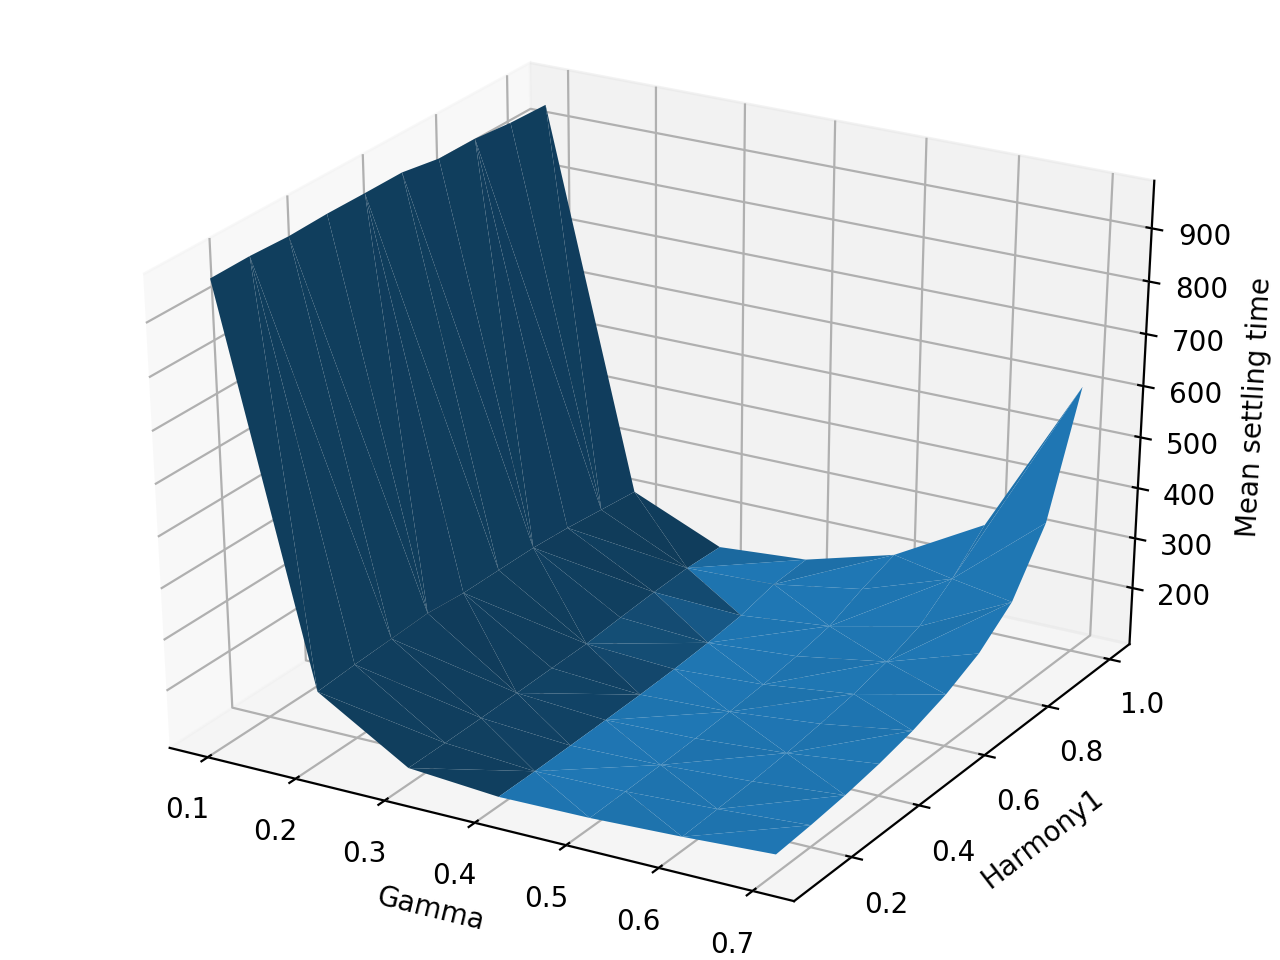

In [45]:
# Plotting the surface
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(agg2.Gamma, agg2.Harmony1, agg2.Time, linewidth=0.5, antialiased=True)
ax.set_xlabel('Gamma')
ax.set_ylabel('Harmony1')
ax.set_zlabel('Mean settling time')
plt.show()

<IPython.core.display.Javascript object>


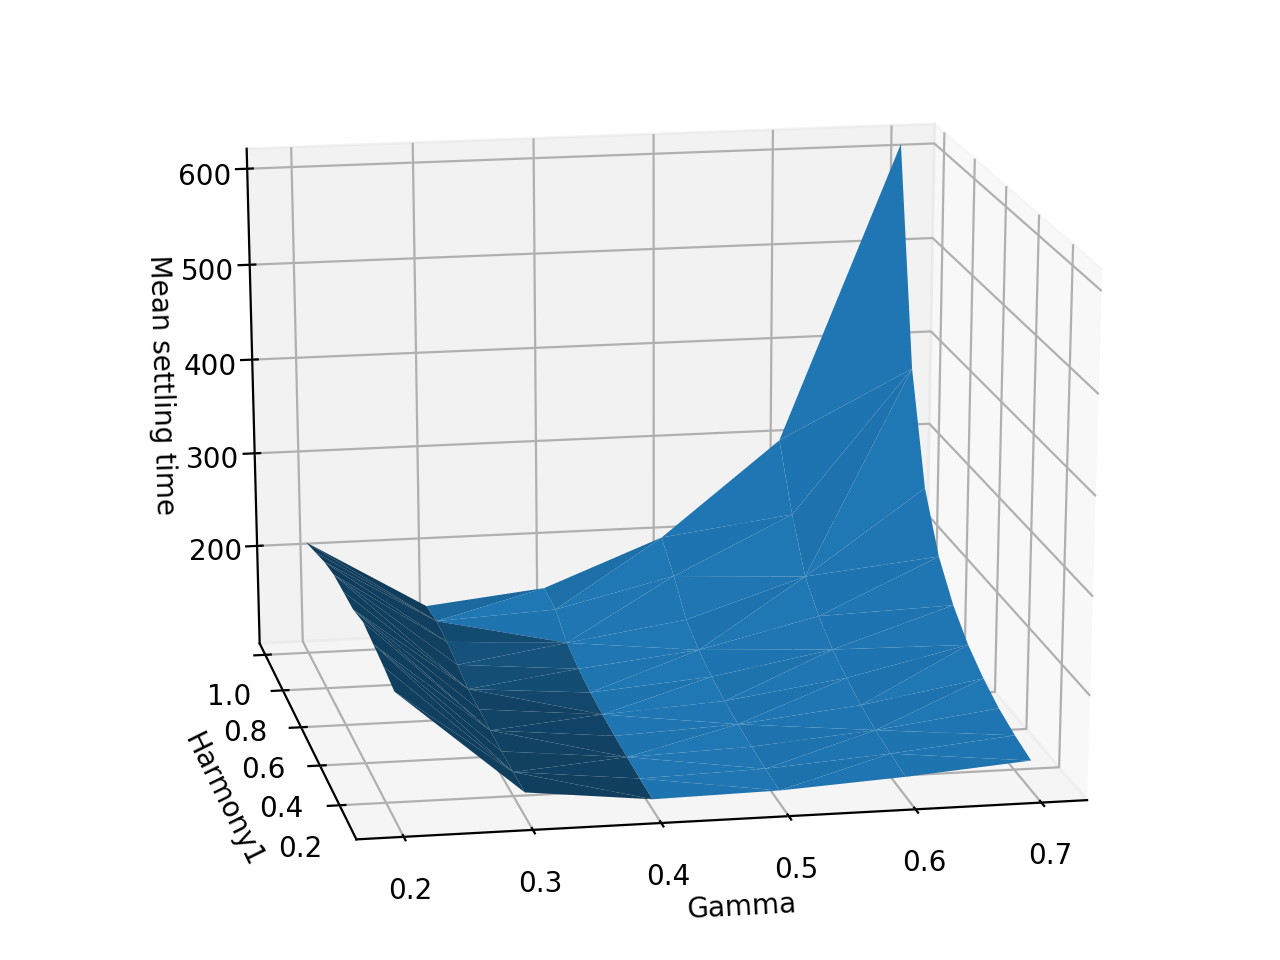

In [46]:
# For gamma < 0.2, it basically never finds an attractor, so let's zoom in, leaving that out
agg_subset = agg2.loc[agg2.Gamma >= 0.2,]
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(agg_subset.Gamma, agg_subset.Harmony1, agg_subset.Time, linewidth=0.5, antialiased=True)
ax.set_xlabel('Gamma')
ax.set_ylabel('Harmony1')
ax.set_zlabel('Mean settling time')
plt.show()

**check stopping criterion for this, although, for $\gamma <= 0.7$, there should be separate attractors**